In [1]:
import ipympl
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io as io
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# Data directory
# datadir = '/home/justin/Data/seam/'
# datadir = '/mnt/c/Users/Justin/Dropbox (Personal)/Shared/Haneet/Data/'
datadir = '/Users/jgranek/Dropbox/Shared/Haneet/Data/'
d_train_f = datadir + 'training_data.mat'
d_test_f = datadir + 'blind_data.mat'

In [3]:
# Load the matlab files for training and testing (blind) boreholes
d_train = io.loadmat(d_train_f)
d_test = io.loadmat(d_test_f)

In [4]:
# Set up the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
device = 'cpu'

In [6]:
# Parse the matlab data structures to get training/testing images and labels
labels_train,images_train = d_train['ctrain'][0],d_train['dtrain'][0]
labels_test,images_test = d_test['cblind'][0],d_test['dblind'][0]

In [ ]:
labels_train[0].shape

In [7]:
# Manually trim the holes to below 450
for i,(c,x) in enumerate(zip(labels_train, images_train)):
    labels_train[i] = c[:,450:]
    images_train[i] = x[:,450:]

for i,(c,x) in enumerate(zip(labels_test, images_test)):
    labels_test[i] = c[:,450:]
    images_test[i] = x[:,450:]

In [8]:
labels_train[0].shape

(4, 257)

In [9]:
# Print some information
print(' ### INFO ###')
print('%i Training Data Boreholes' %(len(images_train)))
print('%i Testing Data Boreholes' %(len(images_test)))
print('%i Classes' %(labels_train[0].shape[0]))
print('%i Values per Image (%i x %i)\n'%(images_train[0].shape[0], np.sqrt(images_train[0].shape[0]), np.sqrt(images_train[0].shape[0])))

cnt = 1
for x,l in zip(images_train,labels_train):
    xv = np.reshape(x,x.size)
    print('Borehole %2i:  %i Depth Slices | Min: %-4.3f   Max: %-4.3f   Mean: % 7.2f   Std: %-4.3f' %(cnt, x.shape[1], xv.min(), xv.max(), xv.mean(), xv. std()))
    cnt += 1

 ### INFO ###
11 Training Data Boreholes
5 Testing Data Boreholes
4 Classes
25 Values per Image (5 x 5)

Borehole  1:  257 Depth Slices | Min: -16245.488   Max: 28279.582   Mean: -119.85   Std: 5474.748
Borehole  2:  239 Depth Slices | Min: -14168.395   Max: 27663.824   Mean: -104.43   Std: 4849.029
Borehole  3:  247 Depth Slices | Min: -9568.859   Max: 9519.426   Mean:    3.75   Std: 2938.302
Borehole  4:  241 Depth Slices | Min: -8230.820   Max: 8470.801   Mean:  -41.67   Std: 3067.663
Borehole  5:  210 Depth Slices | Min: -8713.016   Max: 13285.695   Mean:   58.52   Std: 3353.653
Borehole  6:  226 Depth Slices | Min: -16621.117   Max: 29092.922   Mean:  -58.01   Std: 5189.486
Borehole  7:  252 Depth Slices | Min: -16021.473   Max: 30714.266   Mean:  -98.55   Std: 5300.528
Borehole  8:  256 Depth Slices | Min: -9751.035   Max: 15645.852   Mean:   -4.67   Std: 2520.904
Borehole  9:  133 Depth Slices | Min: -12698.621   Max: 17069.480   Mean:  -87.34   Std: 4973.967
Borehole 10:  215 D

In [10]:
# Define a plotting function
def montageArray(x, img_size, ncol=50):
    xx = np.reshape(x, (img_size,img_size,-1))
    fig = plt.figure()
    fig.set_size_inches(30,20)
    fig.subplots_adjust(wspace=0.0)
    n = xx.shape[2]
    for i in range(n):   
        a = fig.add_subplot(np.ceil(n/float(ncol)), ncol, i+1)
        
        plt.imshow(xx[:,:,i])
        plt.axis('off')
    plt.show()
        

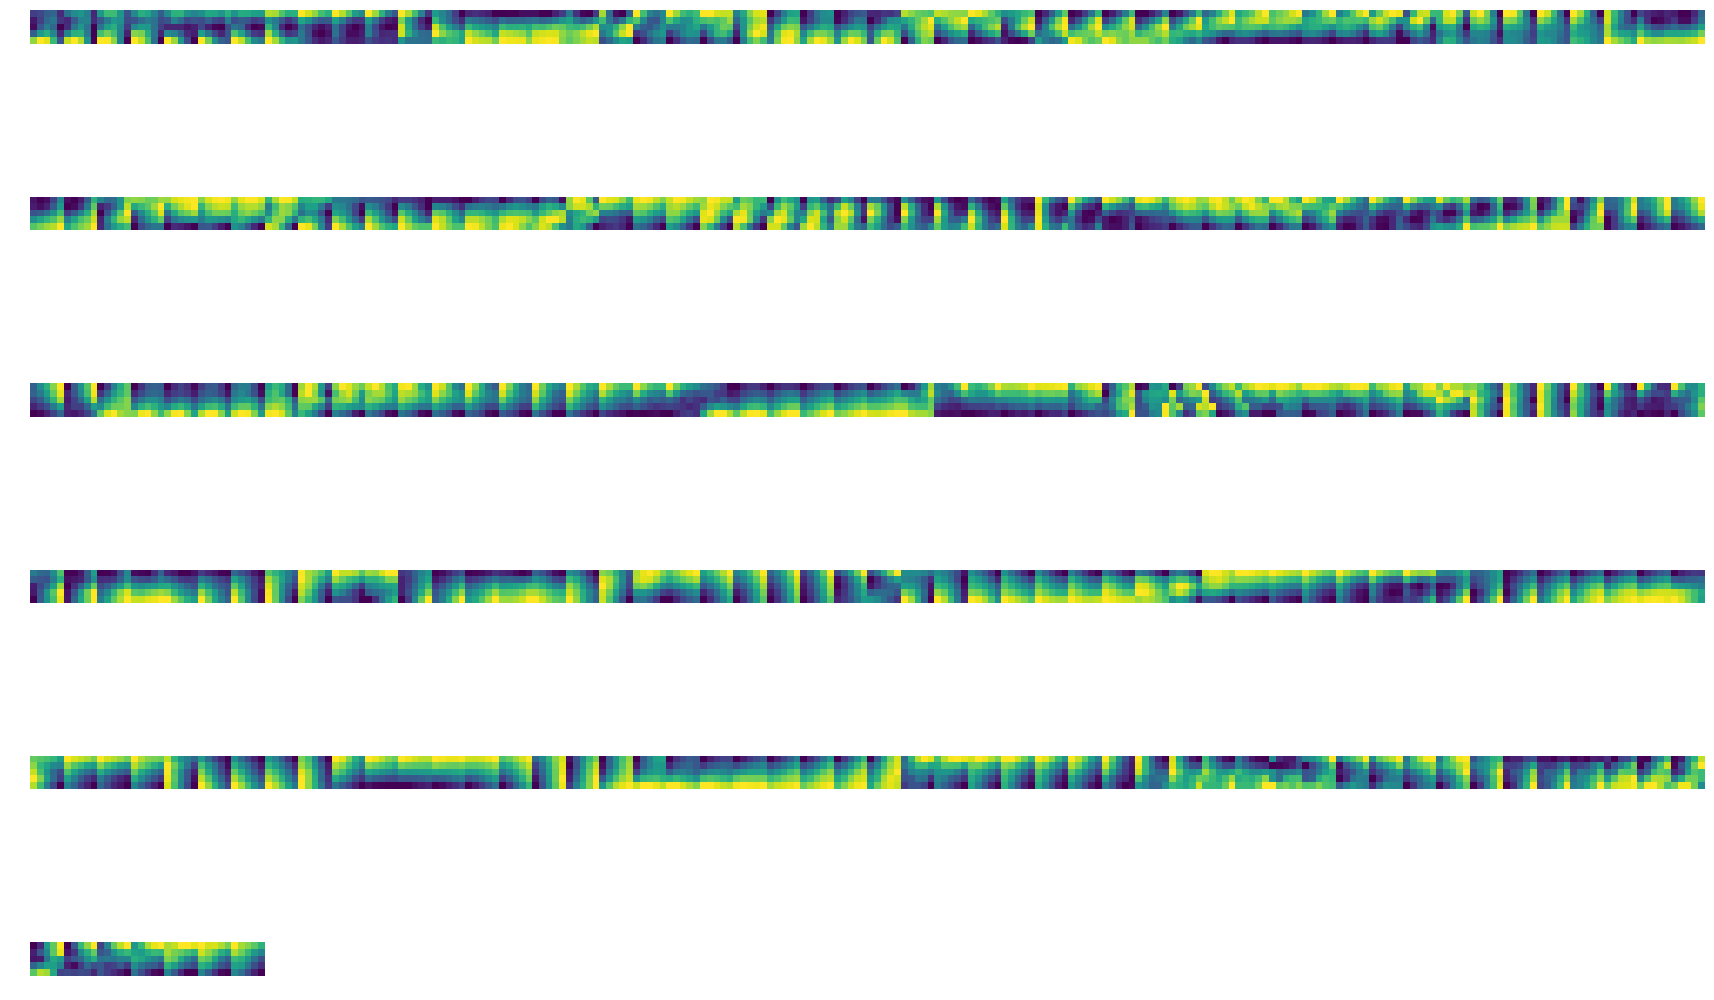

In [11]:
# View the data
montageArray(images_train[0],5)

In [12]:
# Change the labels to integers
alllabels = []
for label in labels_train:
    l = [np.where(y)[0][0] for y in label.transpose()]
    alllabels.append(torch.tensor(np.asarray(l)))
    
testlabels = []
for label in labels_test:
    l = [np.where(y)[0][0] for y in label.transpose()]
    testlabels.append(torch.tensor(np.asarray(l)))
    
# print(alllabels)    

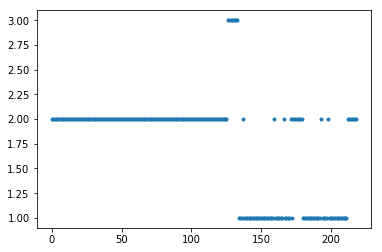

In [13]:
plt.plot(alllabels[10].numpy()[:],'.')

In [128]:
# Get weights to rebalance the problem
cw = np.zeros(labels_train[0].shape[0],dtype=np.float32)
for i in range(len(cw)):
    for label in alllabels:
        cw[i] += np.sum(label.numpy()==i)

# w_l = torch.tensor(1/cw)
w_l = torch.tensor((1/cw)/np.sum(1/cw))
# w_l = torch.tensor( 1 - cw/np.sum(cw))

# Move to the GPU
w_l = w_l.to(device)

In [15]:
for i,(ci,wi) in enumerate(zip(cw,w_l)):
    print('Class %i:  %4i examples  |  weight = %.5f'%(i,ci,wi))


Class 0:    38 examples  |  weight = 0.47296
Class 1:   569 examples  |  weight = 0.03159
Class 2:  1851 examples  |  weight = 0.00971
Class 3:    37 examples  |  weight = 0.48574


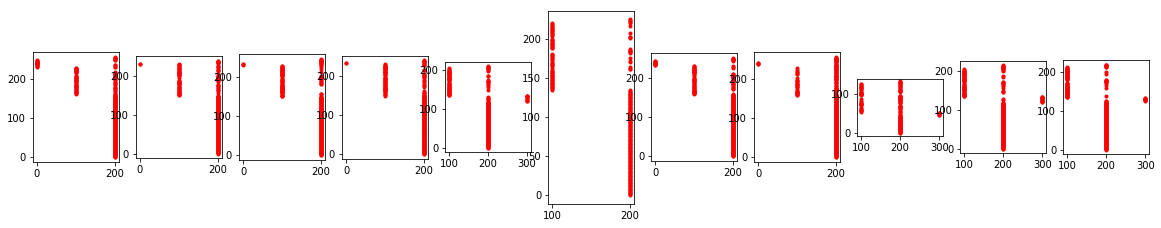

In [16]:
# View the labels
fig = plt.figure(figsize=(20,10))
for i,ll in enumerate(alllabels):
    a = fig.add_subplot(1, len(alllabels), i+1)
    plt.plot(100*ll.numpy(),np.arange(len(ll.numpy())),'r.')
    plt.axis('image')
plt.show()

In [17]:
# Normalize the data
alldata = np.concatenate([x.flatten() for x in images_train])
m,s,ma,mi = alldata.mean(),alldata.std(),alldata.max(),alldata.min()
print(m,s,ma,mi)

newd = 2*(alldata - mi)/(ma-mi)-1
print(newd.max(),newd.min(),newd.mean(),newd.std())

Ynorm = [2*(y-mi)/(ma-mi)-1 for y in images_train]
Ynormtest = [2*(y-mi)/(ma-mi)-1 for y in images_test]

-51.06885505251989 4200.418730964761 30714.265625 -16621.1171875
1.0 -1.0 -0.2998874267867217 0.1774747971344406


In [18]:
# Format the data and labels for PyTorch
# Images should be formatted as [1,1,X,Y,Z] for each Borehole
Ytrain = []
for y in Ynorm:
    Ytrain.append(torch.tensor(np.float32(np.reshape(y,(1,1,5,5,-1)))))
    
Ytest = []
for y in Ynormtest:
    Ytest.append(torch.tensor(np.float32(np.reshape(y,(1,1,5,5,-1)))))

In [205]:
q = np.zeros((1,2,5,5,3))
q[:,:,:,:,0] = 1
q[:,:,:,:,1] = 2
q[:,:,:,:,2] = 3
qq = torch.tensor(np.float32(q))
print(qq.shape)

qqq = qq.reshape((50,3))


torch.Size([1, 2, 5, 5, 3])


tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.])

In [129]:
def conv3x3x3(x,K):
    """3x3 convolution with padding"""
    return F.conv3d(x, K, padding=1)

def conv3x3x3T(x,K):
    """3x3 convolution transpose with padding"""
    #K = torch.transpose(K,0,1)
    return F.conv_transpose3d(x, K, padding=1)
        
        
# w_l[:] = 1        
dis = nn.CrossEntropyLoss(weight=w_l)
def misfit(X, W, C):    
    n  = W.shape
    Xv = X.view(n[0], -1)
    S  = torch.matmul(W.t(), Xv)
    return dis(S.t(), C), S.t()   


def getAccuracy(S,labels):
    _, predicted = torch.max(S.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct/total

In [206]:
class ResNet(nn.Module):

    def __init__(self, h,NG):
        super().__init__()

        # network geometry
        self.NG       = NG
        # time step
        self.h        = h
        # coarsening and TV norm
        
        
    def forward(self,x,Kresnet):
    
        nt = len(Kresnet)
        
        # time stepping
        for j in range(nt):
            
            # First case - rsent style step
            if NG[0,j] == NG[1,j]: 
                #print(torch.norm(z))
                z  = conv3x3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                z  = F.relu(z)        
                z  = conv3x3x3T(z,Kresnet[j])
                x  = x - self.h*z
            # Change number of channels/resolution    
            else:
                z  = conv3x3x3(x, Kresnet[j])
#                 z  = F.instance_norm(z)
                x  = F.relu(z)
        
        # compress in x-y dimensions 
        #x = F.avg_pool3d(x, (5,5,1), stride=None, padding=0)
             
        return x #torch.transpose(p,0,1)
        

In [47]:
NG = [1,     16,     16,    16,   16,   32,   32,  
      16,    16,     16,    16,   32,   32,   32,
      0,      0,      0,     0,    0,    0,    0]

NG = np.reshape(NG,(3,-1))
NG

array([[ 1, 16, 16, 16, 16, 32, 32],
       [16, 16, 16, 16, 32, 32, 32],
       [ 0,  0,  0,  0,  0,  0,  0]])

In [207]:
# initialize net and weights
h           = 1e-1

# Network geometry
#NG = [1,     16,     16,    16,   16,   32,   32,  
#      16,    16,     16,    16,   32,   32,   32,
#      0,      0,      0,     0,    0,    0,    0]

# NG = [1,     16,     16,    16,  
#       16,    16,     16,    16,
#       0,      0,      0,     0]

NG = [1,
      256,
      0]


NG = np.reshape(NG,(3,-1))


net   = ResNet(h,NG)

nsteps = NG.shape[1]


Kresnet = []
for i in range(nsteps):  
    Ki  = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]),3,3,3))
    stdv  = 1e-3
    Ki.data.uniform_(-stdv, stdv)    
    # Move to the GPU
    Ki.data = Ki.data.to(device)
    
    #print(torch.norm(Ki))
    Kresnet.append(Ki)
    
# weights for linear classifier    
W     = nn.Parameter(torch.Tensor(np.asscalar(NG[1,-1])*25,4))
stdv  = 1e-3
W.data.uniform_(-stdv, stdv)
    
# Move to GPU
net.to(device)
W.data = W.data.to(device)

inputs = Ytrain[0] 
labels = alllabels[0]
inputs, labels = inputs.to(device), labels.to(device)
out    = net(inputs, Kresnet)

Wt = torch.rand(4,400)

S = torch.matmul(Wt,out.view(400,-1))


t1 = dis(S.t(),labels)

print(t1)

In [208]:
import torch.optim as optim
#optimizer = optim.SGD([{'params':Kresnet},{'params': W, 'lr':1e-3}], lr=1e-4, momentum=0)
optimizer = optim.SGD([{'params': W}], lr=1e-1, momentum=0)


# Print every _ iterations
p_iter = 1

# Run _ epochs
n_epoch = 10

In [183]:
inputs = Ytrain[0] 
labels = alllabels[0]
inputs, labels = inputs.to(device), labels.to(device)
x = net(inputs, Kresnet)
loss, Si = misfit(x,W,labels)

tensor(1.6058)
torch.Size([1, 256, 5, 5, 219])


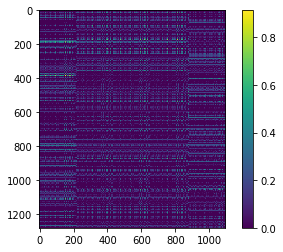

In [190]:
print(loss)
print(x.shape)
plt.imshow(x.view(256*5,-1).detach().numpy())
plt.colorbar()

In [193]:
np.exp(1.386)

3.998822728800372

In [210]:
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    
    print('Epoch   Iteration   Loss(run)   Acc(run)   Acc(val)')
    print('---------------------------------------------------')
    
    for i in range(len(Ytrain)):
        # get the inputs
        inputs = Ytrain[i] 
        labels = alllabels[i]
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x    = net(inputs,Kresnet)
        loss, Si = misfit(x,W,labels)
        Wold = W.detach()
        loss.backward()
             
        optimizer.step()

        # print statistics
        accuracy = getAccuracy(Si,labels)
        running_loss     += loss.item()
        running_accuracy += accuracy
        if i % p_iter == (p_iter-1):    # print every p_iter mini-batches
            # compute validation accuracy
            with torch.no_grad():
                for j in range(len(Ytest)):            
                    #    dataiter = iter(testloader)
                    #    inputsV, labelsV = dataiter.next()
                    inputsV = Ytest[j] 
                    labelsV = testlabels[j]
                    inputsV, labelsV = inputsV.to(device), labelsV.to(device)
                    xV = net(inputsV,Kresnet)
                    lossV, SiV = misfit(xV,W,labelsV)
                    accuracyV  = getAccuracy(SiV,labelsV)

#             accuracyV = 0
            print(' %2d      %5d        %5.3f      %5.3f      %5.3f          |       %5.3f' %
                  (epoch + 1, i + 1, running_loss / p_iter, running_accuracy/p_iter, accuracyV, torch.norm(W)))
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

Epoch   Iteration   Loss(run)   Acc(run)   Acc(val)
---------------------------------------------------
  1          1        1.386      0.233      0.819          |       0.096
  1          2        1.386      0.741      0.833          |       0.097
  1          3        1.386      0.737      0.833          |       0.097
  1          4        1.386      0.755      0.833          |       0.097
  1          5        1.387      0.681      0.819          |       0.097
  1          6        1.386      0.664      0.154          |       0.098
  1          7        1.386      0.206      0.154          |       0.098
  1          8        1.386      0.145      0.833          |       0.098
  1          9        1.387      0.677      0.819          |       0.098
  1         10        1.386      0.688      0.493          |       0.098
  1         11        1.386      0.534      0.167          |       0.097
Epoch   Iteration   Loss(run)   Acc(run)   Acc(val)
-----------------------------------------

In [ ]:
# Predict
for testi in range(len(testlabels)):
    yt = Ytest[testi].to(device)
    ct = testlabels[testi].to(device)
    x = net(yt,Kresnet)
    _,pred = misfit(x,W,ct)

    correct = (np.argmax(pred.detach(),axis=1)==ct.cpu()).numpy()
    print(' Test Hole %i: %3i/%3i Correct  (%.2f%%)'%(testi,correct.sum(),correct.size,100*correct.sum()/correct.size))

In [ ]:
print(ct.shape)
tmp = torch.tensor(np.zeros(50,dtype=np.long),requires_grad=False).to(device)
tmp

In [127]:
# nn.CrossEntropyLoss??

In [125]:
a = torch.tensor([[1, 0, 0],[0, 1, 0],[0, 0, 1]], dtype=torch.float32)
# abig = torch.tensor(np.random., dtype=torch.float32)
b = torch.tensor([0, 1, 2],dtype=torch.long)
bbad = torch.tensor([0, 2, 0],dtype=torch.long)
mydis = nn.CrossEntropyLoss()
print(a)
print(b)
print(mydis(a,b))
print(mydis(a,bbad))

tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])
tensor([ 0,  1,  2])
tensor(0.5514)
tensor(1.2181)


In [ ]:
print(np.argmax(pred.detach(),axis=1))
# print(np.argmax(pred.detach(),axis=1)==testlabels[testi])

In [ ]:
# Good run? Save it!
# torch.save(net.state_dict(),'resnet_params_june14.pth')

In [ ]:
# Load the full model
import h5py
# modelpath = datadir + 'alldata.mat'
modelpath = '/Users/jgranek/Downloads/alldata.mat'
seamfile = h5py.File(modelpath,'r')

In [ ]:
list(seamfile.keys())

In [ ]:
print(np.array(seamfile.get('o')))
print(np.array(seamfile.get('n')))
print(np.array(seamfile.get('d')))

seammodel = seamfile.get('data')

In [ ]:
seammodel.shape

In [ ]:
# Plot some slices
plt.figure(figsize = (20,5))
plt.imshow(seammodel[:,10,151:-50].transpose(),cmap='gray',clim=(-10000,10000),extent=[0,15,0,5])
plt.colorbar()
plt.axis('image')
plt.show()

In [ ]:
# Load a good model
saved_model_file = 'resnet_params_june14.pth'
net.load_state_dict(torch.load(saved_model_file))

# Loop over the model and create predictions for every pixel
cnt = 0

# Initialize the output model
out = np.zeros((650,660,850))

# Dummy labels for the misfit function (not actually used..but required)
cdummy = torch.tensor(np.zeros(850,dtype=np.long),requires_grad=False).to(device)

# Just FYI...
cnt_end = len(range(3,seammodel.shape[0]-2,5))*len(range(3,seammodel.shape[1]-2,5))
print('There will be %i passes through the network...starting now...'%cnt_end)

# Loop over x
for ix in range(3,seammodel.shape[0]-2,5):
# for ix in range(3,50,5): # For testing..

    # Loop over y
    for iy in range(3,seammodel.shape[1]-2,5):
#     for iy in range(3,50,5): # For testing..

        # Grab a 5x5x850 volume of the model
        di = seammodel[ (ix-3):(ix+2), (iy-3):(iy+2), 101:-50]
        
        # Standardize (using previous max and min from training set)
        di_n = 2*(di-mi)/(ma-mi)-1
        
        # Create a torch tensor on the GPU
        ypred = torch.tensor(np.float32(np.reshape(di_n,(1,1,5,5,-1)))).to(device)
        
        # Run the network
        x = net(ypred,Kresnet)
        _, pred = misfit(x,W,cdummy)
        
        # Store the values in the model
        out[(ix-3):(ix+2), (iy-3):(iy+2), :] = np.tile(np.argmax(pred.detach(),axis=1),(5,5,1))
        
        # Counter
        cnt += 1
        print('%i..'%cnt, end='');



In [ ]:
# Plot some slices
plt.figure(figsize = (20,5))
plt.imshow(out[:50,5,:].transpose(),cmap='gray',clim=(0,3),extent=[0,15,0,5])
plt.colorbar()
plt.axis('image')
plt.show()